# Planning a meal with a quantum computer

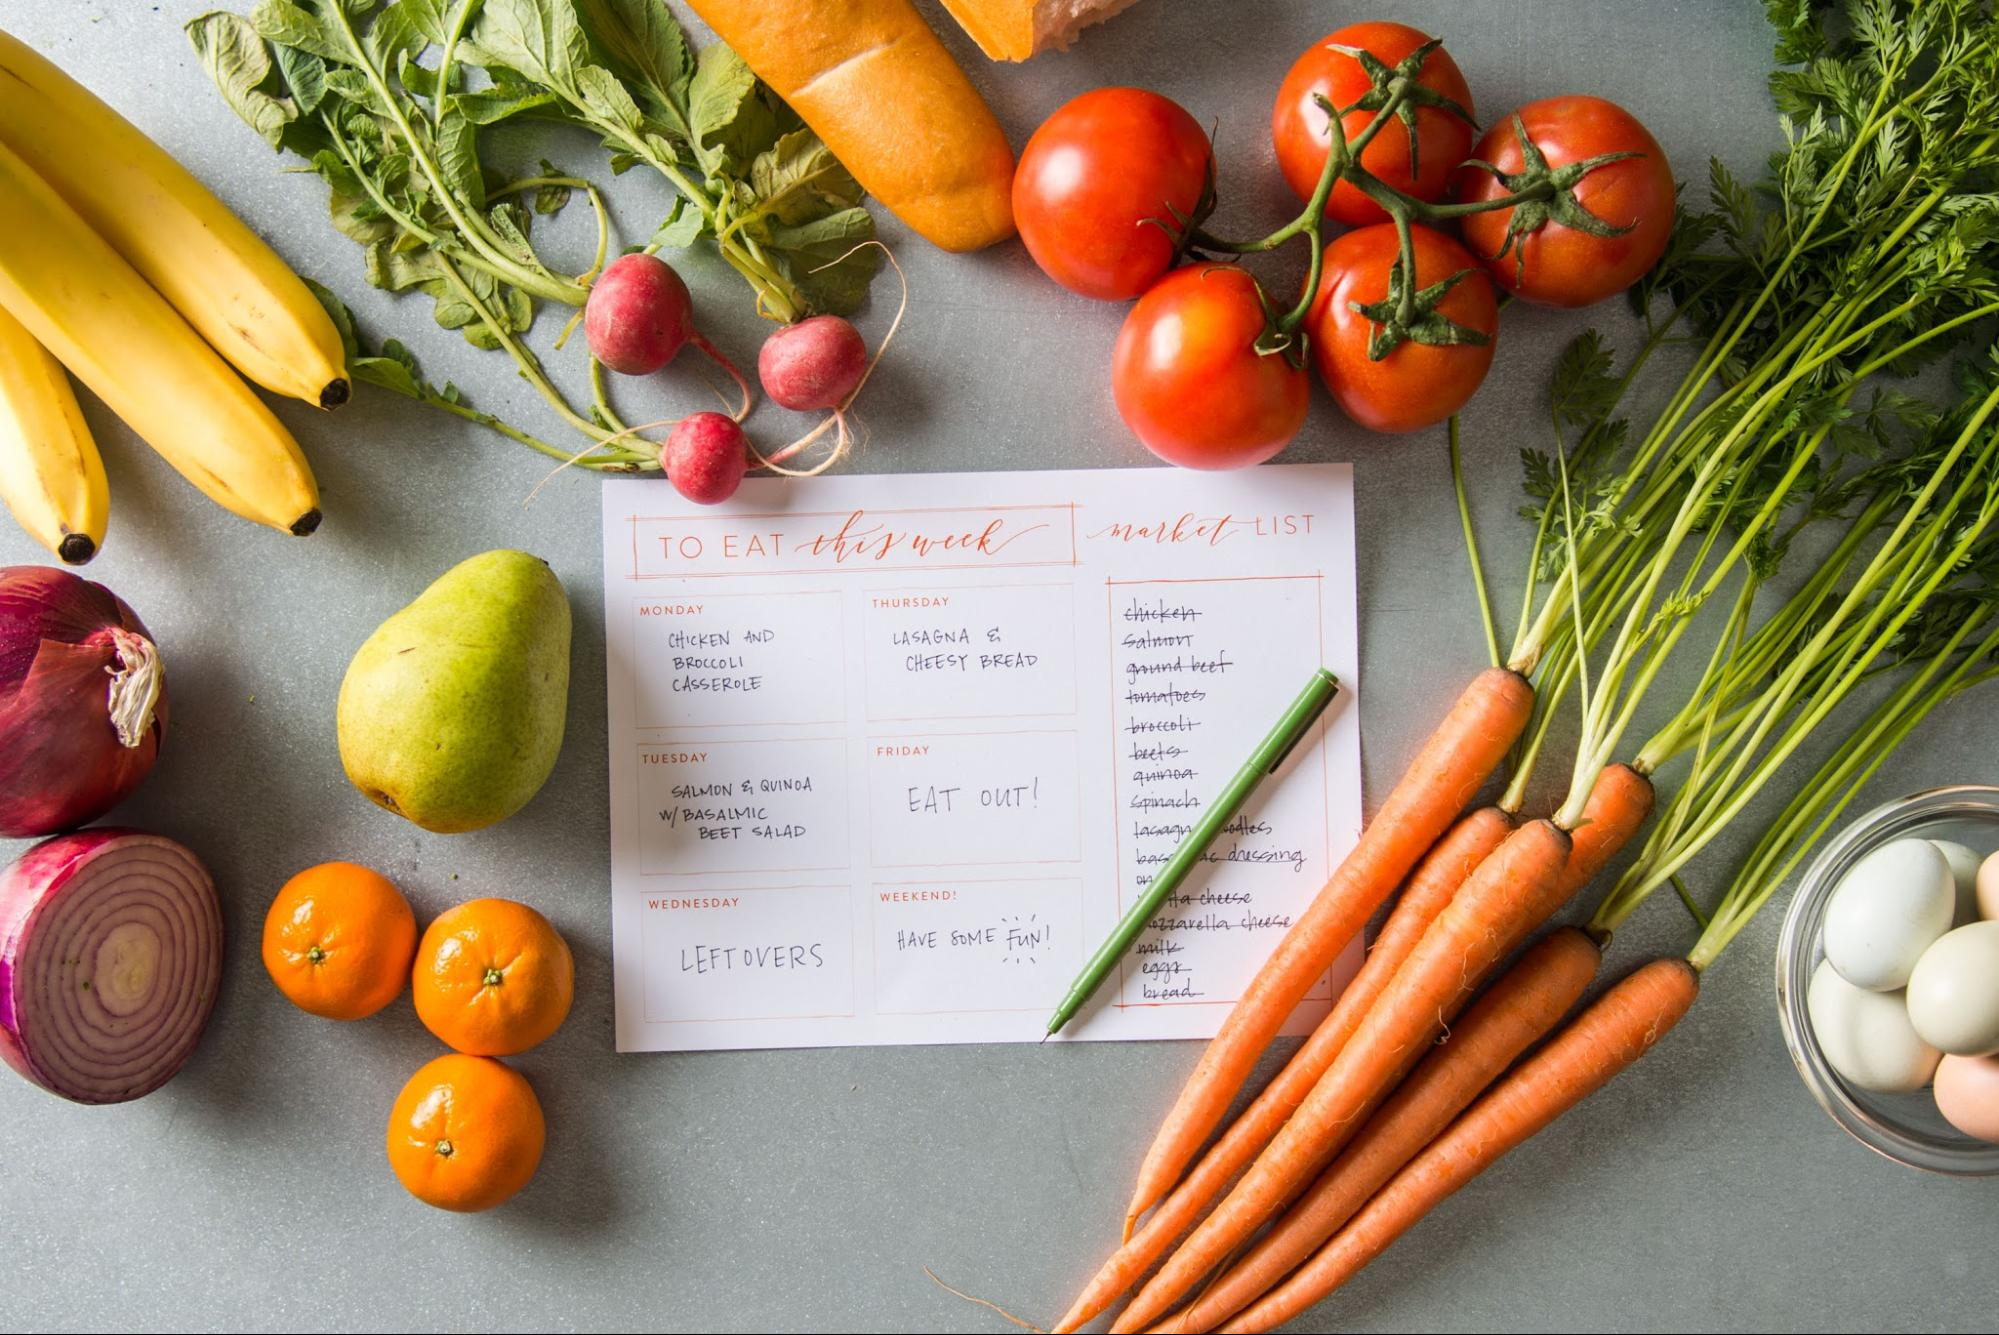

In [1]:
import matplotlib

import dimod

In [2]:
import itertools
from dwave.system import DWaveSampler, EmbeddingComposite
from dwave.cloud import Client

In [3]:
client = Client.from_config(config_file=r'C:\Users\Ingrid\AppData\Local\dwavesystem\dwave\dwave.conf')  # doctest: +SKIP


## Formulating the problem

In [4]:
foods = {

  'rice': {'Calories': 100, 'Protein': 3, 'Fat': 1, 'Carbs': 22, 'Fiber': 2,

           'Taste': 7, 'Cost': 2.5, 'Units': 'continuous'},

  'tofu': {'Calories': 140, 'Protein': 17, 'Fat': 9, 'Carbs': 3, 'Fiber': 2,

           'Taste': 2, 'Cost': 4.0, 'Units': 'continuous'},

  'banana': {'Calories': 90, 'Protein': 1, 'Fat': 0, 'Carbs': 23, 'Fiber': 3,

             'Taste': 10, 'Cost': 1.0, 'Units': 'discrete'},

  'lentils': {'Calories': 150, 'Protein': 9, 'Fat': 0, 'Carbs': 25, 'Fiber': 4,

              'Taste': 3, 'Cost': 1.3, 'Units': 'continuous'},

  'bread': {'Calories': 270, 'Protein': 9, 'Fat': 3, 'Carbs': 50, 'Fiber': 3,

            'Taste': 5, 'Cost': 0.25, 'Units': 'continuous'},

  'avocado': {'Calories': 300, 'Protein': 4, 'Fat': 30, 'Carbs': 20, 'Fiber': 14,

              'Taste': 5, 'Cost': 2.0, 'Units': 'discrete'}}



In [5]:
min_nutrients = {"Protein": 50, "Fat": 30, "Carbs": 130, "Fiber": 30}

max_calories = 2000

In [6]:

quantities = [dimod.Real(f"{food}") if foods[food]["Units"] == "continuous"

                                    else dimod.Integer(f"{food}")

                                    for food in foods.keys()]


In [7]:
for ind, food in enumerate(foods.keys()):

  ub = max_calories / foods[food]["Calories"]

  quantities[ind].set_upper_bound(food, ub)

In [8]:
def total_mix(quantity, category):

  return sum(q * c for q, c in zip(quantity, (foods[food][category] for food in foods.keys())))



In [9]:

cqm = dimod.ConstrainedQuadraticModel()

In [10]:
cqm.set_objective(-total_mix(quantities, "Taste") + 6*total_mix(quantities, "Cost"))


In [11]:
cqm.add_constraint(total_mix(quantities, "Calories") <= max_calories, label="Calories")


'Calories'

In [12]:
for nutrient, amount in min_nutrients.items():
  cqm.add_constraint(total_mix(quantities, nutrient) >= amount, label=nutrient)
  

In [13]:
list(cqm.constraints.keys())
print(cqm.constraints["Calories"].to_polystring())
print(cqm.constraints["Protein"].to_polystring())

100*rice + 140*tofu + 90*banana + 150*lentils + 270*bread + 300*avocado <= 2000.0
3*rice + 17*tofu + banana + 9*lentils + 9*bread + 4*avocado >= 50.0


## Solving the problem 

In [14]:
from dwave.system import LeapHybridCQMSampler
sampler = LeapHybridCQMSampler() 

In [15]:
sampleset = sampler.sample_cqm(cqm)                    

feasible_sampleset = sampleset.filter(lambda row: row.is_feasible)   

print("{} feasible solutions of {}.".format(len(feasible_sampleset), len(sampleset)))  


34 feasible solutions of 52.


## Looking at one of the solutions

In [16]:
def print_diet(sample):
   diet = {food: round(quantity, 1) for food, quantity in sample.items()}
   print(f"Diet: {diet}")
   taste_total = sum(foods[food]["Taste"] * amount for food, amount in sample.items())
   cost_total = sum(foods[food]["Cost"] * amount for food, amount in sample.items())
   print(f"Total taste of {round(taste_total, 2)} at cost {round(cost_total, 2)}")
   for constraint in cqm.iter_constraint_data(sample):
      print(f"{constraint.label} (nominal: {constraint.rhs_energy}): {round(constraint.lhs_energy)}")